You can check <font color='red'>red comments</font> to see differences between TP3 and TP4.

## Importing libraries

In [92]:
import nltk
import pandas as pd
import numpy as np
import re
import seaborn as sn
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, ShuffleSplit, cross_val_predict, KFold
from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim import corpora, models

In [93]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading and pre-processing the data

Loading the data with a ',' (comma) separator. 

In [94]:
# We use the sample function to take randomly n rows because the dataset is too long (1.6m rows) 
dataset = pd.read_csv('english_tweets.csv', sep = ',', encoding='utf8').sample(n = 5000, random_state = 1)
dataset['label'] = dataset['label'].replace(4, 1)

# Reset index after the sample function 
dataset.reset_index(drop = True, inplace = True)

Loading stopwords from the dedicated NLTK library.

In [95]:
stop_words_en = set(stopwords.words("english"))

Functions to pre-process the text by removing any useless stuff.
We choosed 2 preprocessing :
  - One by using lemmatization
  - One by not using lemmatization (default)

We removed stop_words in both functions.

In [96]:
def getWordnetPos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tagDict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tagDict.get(tag, wordnet.NOUN)

def preprocessWithLemmatization(column):
    corpus = []
    
    lemmatizer = WordNetLemmatizer()
    
    for i in range(0, len(column)):
        # Remove sites and twitter tags
        text = re.sub('(http[^\s]+|@[^\s]+)', ' ', column.iloc[i])
        
        # Remove punctuations
        text = re.sub('[^A-Za-zÀ-ÖØ-öø-ÿ]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Convert to list from string
        text = text.split() 
        
        # Lemmatization of each word of a row
        for word in text:
            word = lemmatizer.lemmatize(word, getWordnetPos(word));
        
        # Remove stop words
        text = ' '.join(word.strip() for word in text if not word in stop_words_en)

        corpus.append(text)
        
    return corpus

def preprocessWithoutLemmatization(column):
    corpus = []
    
    for i in range(0, len(column)):
        # Remove sites and twitter tags
        text = re.sub('(http[^\s]+|@[^\s]+)', ' ', column.iloc[i])
        
        # Remove punctuations
        text = re.sub('[^A-Za-zÀ-ÖØ-öø-ÿ]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Convert to list from string
        text = text.split() 
        
        # Remove stop words
        text = ' '.join(word.strip() for word in text if not word in stop_words_en)

        corpus.append(text)
        
    return corpus

Transform words to numbers by using the TF-IDF vectorizer.

<font color='red'>Create a TruncatedSVD model which is the same as a PCA model but for sparse matrix (given by tf-idf vectorizer).
    
We tried several values for the parameter n_components and it has ended that 500 was the best one because increasing the value won't increase the accuracy so much but the computing time will be exponentially much longer.</font>



In [97]:
tfidf = TfidfVectorizer(stop_words = stop_words_en)

svd = TruncatedSVD(n_components = 500, random_state = 1)

datasetWithLemmatization = dataset
datasetWithoutLemmatization = dataset

datasetWithLemmatization['text'] = preprocessWithLemmatization(datasetWithLemmatization['text'])
datasetWithoutLemmatization['text'] = preprocessWithoutLemmatization(datasetWithoutLemmatization['text'])

datasetWithLemmatizationX = tfidf.fit_transform(datasetWithLemmatization['text'])
datasetWithLemmatizationX = svd.fit_transform(datasetWithLemmatizationX)

datasetWithLemmatizationY = datasetWithLemmatization['label']

datasetWithoutLemmatizationX = tfidf.fit_transform(datasetWithoutLemmatization['text'])
datasetWithoutLemmatizationX = svd.fit_transform(datasetWithoutLemmatizationX)

datasetWithoutLemmatizationY = datasetWithoutLemmatization['label']

<font color='red'>With a value of 500 for n_components, we have 50% of explained variance.</font>

In [98]:
print(sum(svd.explained_variance_ratio_))

0.4949106784508059


## Build and compare classifiers using cross validation method 

Function that cross validates and creates the confusion matrix for each of our instance of algorithms. We choosed to cross validate using 5 splits.
The function returns an array with all the data needed to compare them with each other : accuracy, precision, recall, f1 score, confusion matrix and execution time.

In [99]:
def scores(clf, X, y):
    confusionMatrixArray = []

    # Randomly split the dataset in 5 parts 
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

    accuracyArray, precisionArray, recallArray, f1Array, timeArray = [], [], [], [], []
    
    # Test each split (from KFold) while the others are used for training (repeated 5 times)
    for train_index, test_index in kf.split(X):
        startTime = time.time()
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Training for 4/5 splits
        clf.fit(X_train, y_train)

        # Testing for 1/5 splits
        y_pred = clf.predict(X_test)

        # Saving scores in array
        accuracyArray.append(metrics.accuracy_score(y_test, y_pred))
        precisionArray.append(metrics.precision_score(y_test, y_pred))
        recallArray.append(metrics.recall_score(y_test, y_pred))
        f1Array.append(metrics.f1_score(y_test, y_pred))

        confusionMatrixArray.append(confusion_matrix(y_test, y_pred))

        endTime = time.time()

        timeArray.append(endTime - startTime)

    # Compute the mean value of each score/confusion matrix
    confusionMatrix = np.mean(confusionMatrixArray, axis = 0)

    accuracy = np.mean(accuracyArray)
    precision = np.mean(precisionArray)
    recall = np.mean(recallArray)
    f1 = np.mean(f1Array)
    
    executionTime = np.mean(timeArray)
    
    return [accuracy, precision, recall, f1, confusionMatrix, executionTime]

Function that takes a score array and a title and then prints the accuracy, precision, recall, f1 score, execution time and confusion matrix of a classifier.

In [100]:
def printScores(scoresArray, title):
    print(title)
    print('  - Accuracy : {0:.2f} %'.format(scoresArray[0] * 100))
    print('  - Precision : {0:.2f} %'.format(scoresArray[1] * 100))
    print('  - Recall : {0:.2f} %'.format(scoresArray[2] * 100))
    print('  - F1 : {0:.2f} %'.format(scoresArray[3] * 100))
    print('Mean time elapsed : {0:.3f} seconds'.format(scoresArray[5]))
    
    # Plot the confusion matrix
    confusionMatrixDataframe = pd.DataFrame(scoresArray[4], range(2), range(2))
    sn.set(font_scale = 1.4)
    sn.heatmap(confusionMatrixDataframe, annot = True, annot_kws = {"size": 16})
    plt.show()

Create both classifiers (Random Forest Classifier and Logistic Regression).

Finally, we print scores of both algorithms (with the different preprocessing).

Scores of RFC with lemmatization :
  - Accuracy : 65.20 %
  - Precision : 66.91 %
  - Recall : 60.51 %
  - F1 : 63.54 %
Mean time elapsed : 4.776 seconds


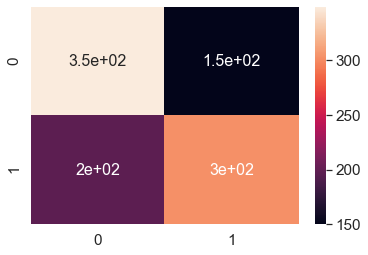

Scores of RFC without lemmatization :
  - Accuracy : 65.28 %
  - Precision : 66.84 %
  - Recall : 61.04 %
  - F1 : 63.80 %
Mean time elapsed : 4.785 seconds


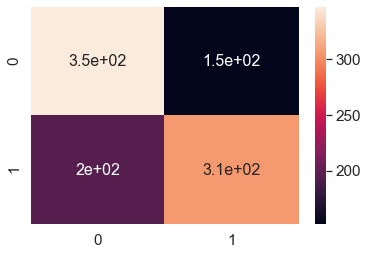

Scores of LR with lemmatization :
  - Accuracy : 70.86 %
  - Precision : 69.89 %
  - Recall : 73.60 %
  - F1 : 71.69 %
Mean time elapsed : 0.101 seconds


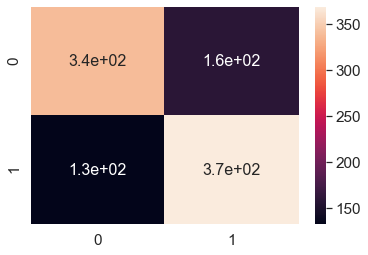

Scores of LR without lemmatization :
  - Accuracy : 70.86 %
  - Precision : 69.89 %
  - Recall : 73.60 %
  - F1 : 71.69 %
Mean time elapsed : 0.054 seconds


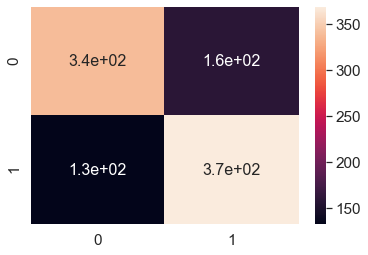

In [101]:
rfc = RandomForestClassifier(n_estimators = 100)

reg = LogisticRegression()

scoresRfcWithLemmatization = scores(rfc, datasetWithLemmatizationX, datasetWithLemmatizationY)
printScores(scoresRfcWithLemmatization, 'Scores of RFC with lemmatization :')

scoresRfcWithoutLemmatization = scores(rfc, datasetWithoutLemmatizationX, datasetWithoutLemmatizationY)
printScores(scoresRfcWithoutLemmatization, 'Scores of RFC without lemmatization :')

scoresLrWithLemmatization = scores(reg, datasetWithLemmatizationX, datasetWithLemmatizationY)
printScores(scoresLrWithLemmatization, 'Scores of LR with lemmatization :')

scoresLrWithoutLemmatization = scores(reg, datasetWithoutLemmatizationX, datasetWithoutLemmatizationY)
printScores(scoresLrWithoutLemmatization, 'Scores of LR without lemmatization :')

## Results and conclusion

We can first note that "Random Forest Classifier" is very long to train and predict while "Logistic Regression" is under 1 second.

Moreover, it seems that lemmatization has no effect on both classifiers.

LR is slightly better in average than RFC and takes less time to compute.

<font color='red'>Results with PCA processing are kindly the same but the average computing time is a bit shorter. It may be more impactful if we take more than 5000 rows.</font>



## Topic Modeling with LDA

In [102]:
# We use the sample function to take randomly n rows because the dataset is too long (1.6m rows) 
datasetLDA = pd.read_csv('english_tweets.csv', sep = ',', encoding='utf8').sample(n = 50000, random_state = 1)

# Reset index after the sample function 
datasetLDA.reset_index(drop = True, inplace = True)

datasetLDA['text'] = preprocessWithLemmatization(datasetLDA['text'])

test = [row['text'].split() for index, row in pd.DataFrame(datasetLDA['text']).iterrows()]

In [103]:
dictionary = corpora.Dictionary(test)

dictionary.filter_extremes(no_below = 1000, no_above = 0.3, keep_n = 5000)

corpus = [dictionary.doc2bow(text) for text in test]

ldamodel = models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes = 20)

print(ldamodel.print_topics(num_topics = 4, num_words = 7))
print()
for index, topic in ldamodel.show_topics(formatted=False, num_words= 7):
    print('Topic: {} \nWords: {}'.format(index + 1, [w[0] for w in topic]))
    print()

[(0, '0.193*"good" + 0.171*"get" + 0.148*"today" + 0.135*"going" + 0.102*"amp" + 0.087*"thanks" + 0.087*"home"'), (1, '0.124*"quot" + 0.122*"love" + 0.115*"got" + 0.097*"one" + 0.096*"know" + 0.090*"im" + 0.080*"well"'), (2, '0.169*"day" + 0.149*"like" + 0.130*"go" + 0.108*"time" + 0.091*"really" + 0.083*"see" + 0.081*"still"'), (3, '0.149*"work" + 0.132*"lol" + 0.129*"back" + 0.125*"u" + 0.101*"new" + 0.101*"night" + 0.091*"think"')]

Topic: 1 
Words: ['good', 'get', 'today', 'going', 'amp', 'thanks', 'home']

Topic: 2 
Words: ['quot', 'love', 'got', 'one', 'know', 'im', 'well']

Topic: 3 
Words: ['day', 'like', 'go', 'time', 'really', 'see', 'still']

Topic: 4 
Words: ['work', 'lol', 'back', 'u', 'new', 'night', 'think']



<font color='red'>We tried to adjust parameters of filter_extrems to obtain significant topics but since our dataset is composed of tweets, which are most likely conversations between people, it doesn't have precise themes.
    
However, we can notice that the vocabulary used here are a lot of short words with strong meanings which is a social media spec.</font> 